### Theory and Working

#### Basic Process:
1. A fixed-amplitude, fixed-width pulse train is generated at the sampling rate
2. The message signal is sampled at each pulse position reference time
3. The pulse is shifted (advanced or delayed) proportionally to the sampled signal amplitude
4. Pulses are transmitted with their time positions carrying the message information

#### Derivation from PWM:
PPM can be derived from PWM by differentiating the PWM waveform:
- PWM contains transitions at variable positions (edges)
- Differentiating extracts these position changes
- Only the pulse position carries information

=== PPM for Radar/Telemetry ===


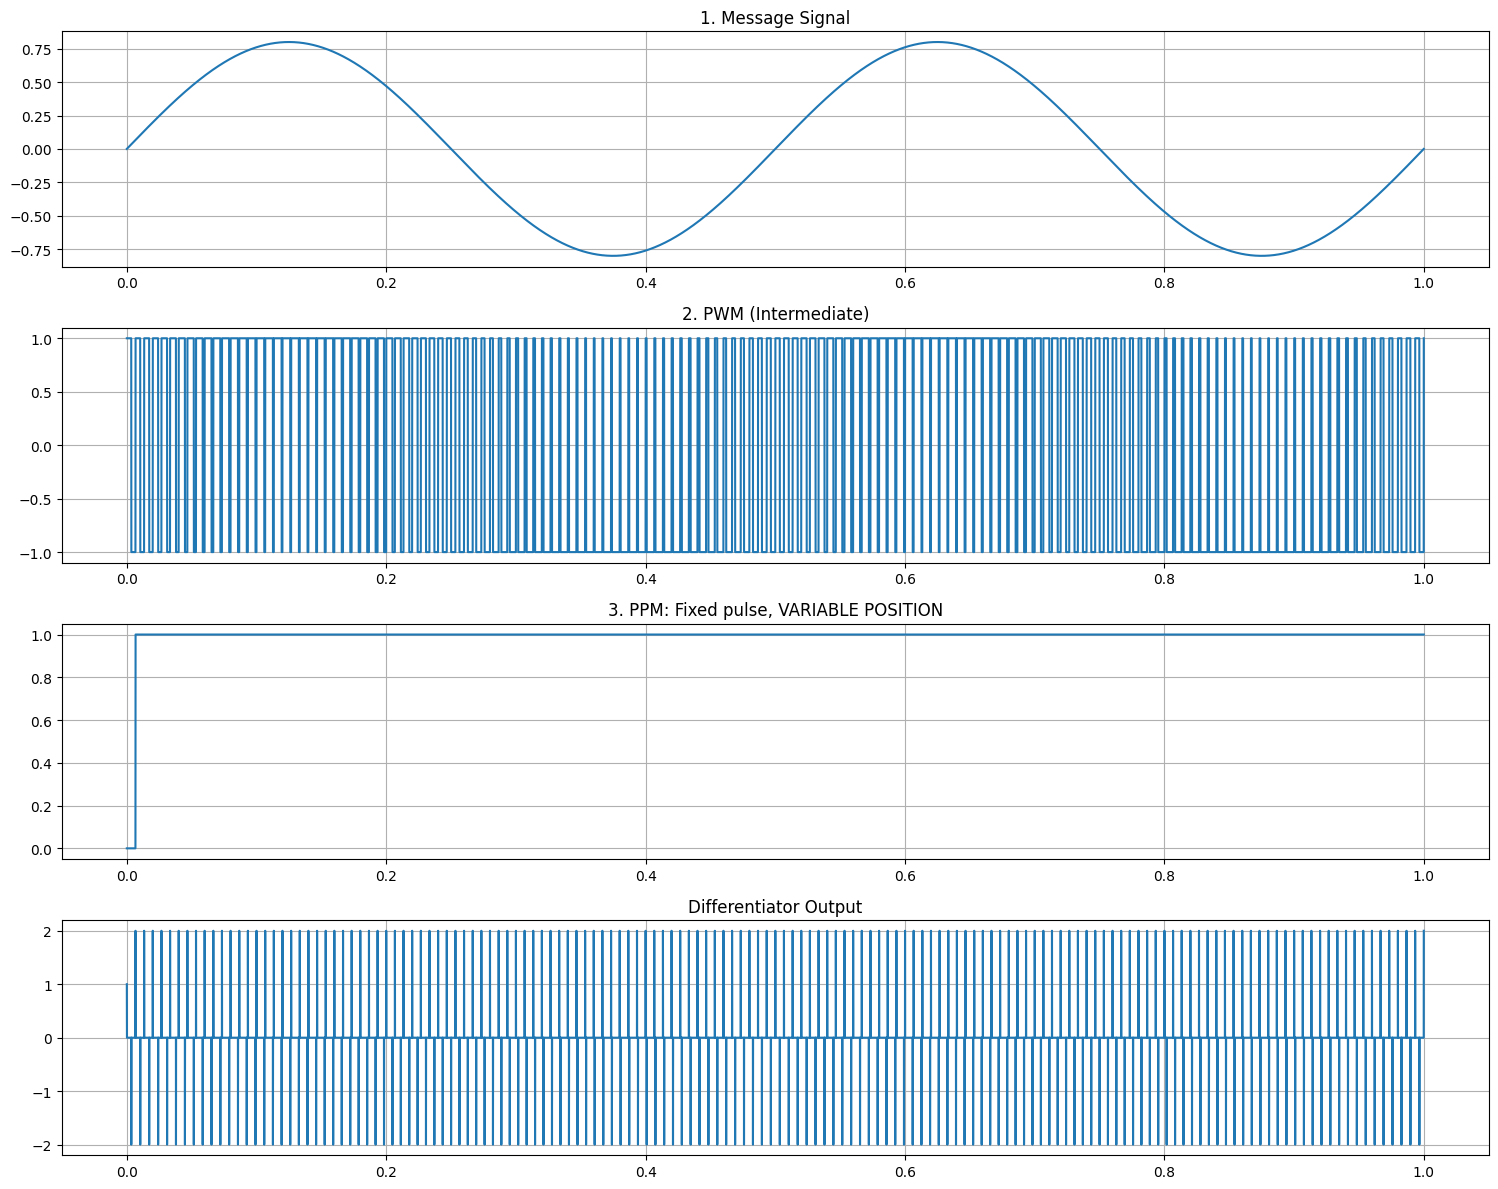

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def generate_ppm(message_freq=5, carrier_freq=100, duration=1):
    """PPM from PWM: Fixed width/amplitude, POSITION varies with message"""
    t = np.linspace(0, duration, 20000)
    msg = 0.8 * np.sin(2*np.pi*message_freq*t)
    
    # Step 1: Generate PWM first
    sawtooth = 2 * (t * carrier_freq % 1) - 1
    pwm = np.where(msg > sawtooth, 1, -1)
    
    # Step 2: Differentiate PWM → PPM (position from leading edge)
    ppm_signal = np.zeros_like(pwm)
    diff = np.diff(pwm, prepend=0)
    
    # Place narrow fixed-width pulses at leading edges (position ∝ msg)
    pulse_width = 0.02  # Fixed narrow pulse
    for i in range(1, len(t)):
        if diff[i] > 0:  # Leading edge detected
            start = i
            end = min(i + int(pulse_width*len(t)), len(t))
            ppm_signal[start:end] = 1
    
    plt.figure(figsize=(15,12))
    plt.subplot(4,1,1); plt.plot(t, msg); plt.title('1. Message Signal'); plt.grid()
    plt.subplot(4,1,2); plt.plot(t, pwm); plt.title('2. PWM (Intermediate)'); plt.grid()
    plt.subplot(4,1,3); plt.plot(t, ppm_signal); plt.title('3. PPM: Fixed pulse, VARIABLE POSITION'); plt.grid()
    plt.subplot(4,1,4); plt.plot(t, diff); plt.title('Differentiator Output'); plt.grid()
    plt.tight_layout(); plt.show()
    
    return ppm_signal, t, msg

print("=== PPM for Radar/Telemetry ===")
ppm_sig, t, msg = generate_ppm(message_freq=2, carrier_freq=150)


### Demodulation of PPM

PPM demodulation involves:
1. **Pulse Detection** - Identifying pulse arrival times relative to reference clock
2. **Time Measurement** - Measuring time displacement from reference
3. **Voltage Conversion** - Converting time displacement to proportional voltage
4. **Low-Pass Filtering** - Extracting the message signal
5. **Amplitude Reconstruction** - Recovering original analog signal

**Key Requirement:** A very stable and accurate reference clock must be available at the receiver (critical for synchronization).

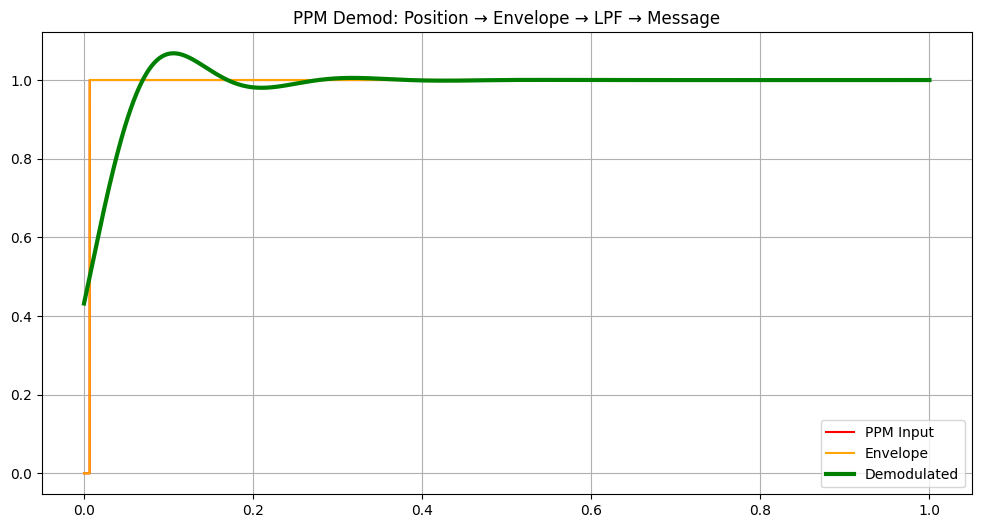

In [7]:
def ppm_demodulator(ppm_signal, t, message_bw=10):
    """PPM Demod: Envelope detect → LPF (position → amplitude)"""
    # Detect pulse positions (envelope)
    envelope = np.abs(ppm_signal)
    fs = len(t)/t[-1]
    
    # LPF recovers message from position variation
    b, a = signal.butter(4, message_bw/(fs/2), btype='low')
    demod = signal.filtfilt(b, a, envelope)
    
    plt.figure(figsize=(12,6))
    plt.plot(t, ppm_signal, 'r', label='PPM Input')
    plt.plot(t, envelope, 'orange', label='Envelope')
    plt.plot(t, demod, 'g', linewidth=3, label='Demodulated')
    plt.title('PPM Demod: Position → Envelope → LPF → Message'); plt.legend(); plt.grid()
    plt.show()
ppm_demodulator(ppm_sig, t, message_bw=5)

### Advantages and Disadvantages

**Advantages:**
- **Best noise immunity** among the three techniques - constant amplitude and width means noise only affects timing[1]
- Information encoded in time domain, independent of amplitude fluctuations
- Superior performance in high-noise environments
- Excellent for long-distance communications
- Suitable for encrypted/secured naval transmissions
- Less affected by amplitude distortion

**Disadvantages:**
- Most complex generation and demodulation circuits
- Requires precise synchronization between transmitter and receiver
- Very sensitive to timing jitter and clock instability
- Highest bandwidth requirement
- More stringent timing accuracy needed in receiver
- Higher cost and complexity of implementation
- Requires stable reference oscillators

### Applications in Naval Systems

**Primary Naval Applications:**

1. **Long-Range Naval Communications** - Secure transmissions over great distances
2. **Submarine Communications** - Extremely low-frequency (ELF) systems use PPM principles
3. **Radar and Sonar Telemetry** - Precise timing information for target ranging and positioning
4. **Satellite Communications** - Naval satellite uplink/downlink systems
5. **Jamming-Resistant Systems** - Military-grade secured communications networks
6. **Range Finding** - Radar distance measurement based on pulse position shift
7. **Torpedo Guidance Systems** - Precise timing control for underwater weapons
8. **Encrypted Naval Networks** - High-security inter-ship communications
9. **Deep-Sea Acoustic Communications** - Long-range underwater telemetry
10. Immunity to amplitude fading in ocean radio propagation
11. Suitable for HF/VHF/UHF long-range naval transmissions
12. Better performance than PAM/PWM in harsh electromagnetic environments
13. Essential for secure military-grade communications